# 实战Kaggle比赛：预测房价
:label:`sec_kaggle_house`

之前几节我们学习了一些训练深度网络的基本工具和网络正则化的技术（如权重衰减、暂退法等）。
本节我们将通过Kaggle比赛，将所学知识付诸实践。
Kaggle的房价预测比赛是一个很好的起点。
此数据集由Bart de Cock于2011年收集 :cite:`De-Cock.2011`，
涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。
这个数据集是相当通用的，不会需要使用复杂模型架构。
它比哈里森和鲁宾菲尔德的[波士顿房价](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)
数据集要大得多，也有更多的特征。

本节我们将详细介绍数据预处理、模型设计和超参数选择。
通过亲身实践，你将获得一手经验，这些经验将有益数据科学家的职业成长。

## 下载和缓存数据集

在整本书中，我们将下载不同的数据集，并训练和测试模型。
这里我们(**实现几个函数来方便下载数据**)。
首先，我们建立字典`DATA_HUB`，
它可以将数据集名称的字符串映射到数据集相关的二元组上，
这个二元组包含数据集的url和验证文件完整性的sha-1密钥。
所有类似的数据集都托管在地址为`DATA_URL`的站点上。


In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

class PoltClass:
    def __init__(self,name):
        self.df = pd.read_csv(name)

    def displayXY(self,xlable,ylable,title="default"):
        plt.plot(self.df[xlable], self.df[ylable])
        plt.xlabel(xlable)
        plt.ylabel(ylable)
        plt.title(title)
        # 显示图表
        plt.show()


下面的`download`函数用来下载数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中，
并返回下载文件的名称。
如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在`DATA_HUB`中的相匹配，
我们将使用缓存的文件，以避免重复的下载。


In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名。

    Parameters:
    - name (str): 文件名，应该存在于DATA_HUB中。
    - cache_dir (str): 缓存目录，默认为'../data'。

    Returns:
    str: 本地文件名。
    """
    # 确保文件名存在于DATA_HUB中
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"

    # 获取文件的下载链接和SHA1哈希值
    url, sha1_hash = DATA_HUB[name]

    # 创建缓存目录
    os.makedirs(cache_dir, exist_ok=True)

    # 构建本地文件路径
    fname = os.path.join(cache_dir, url.split('/')[-1])

    # 如果文件已存在且哈希匹配，则直接返回文件名（命中缓存）
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存

    # 如果文件不存在或者哈希不匹配，从URL下载文件
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)

    # 返回本地文件名
    return fname


我们还需实现两个实用函数：
一个将下载并解压缩一个zip或tar文件，
另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。


In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## Kaggle

[Kaggle](https://www.kaggle.com)是一个当今流行举办机器学习比赛的平台，
每场比赛都以至少一个数据集为中心。
许多比赛有赞助方，他们为获胜的解决方案提供奖金。
该平台帮助用户通过论坛和共享代码进行互动，促进协作和竞争。
虽然排行榜的追逐往往令人失去理智：
有些研究人员短视地专注于预处理步骤，而不是考虑基础性问题。
但一个客观的平台有巨大的价值：该平台促进了竞争方法之间的直接定量比较，以及代码共享。
这便于每个人都可以学习哪些方法起作用，哪些没有起作用。
如果我们想参加Kaggle比赛，首先需要注册一个账户（见 :numref:`fig_kaggle`）。

![Kaggle网站](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

在房价预测比赛页面（如 :numref:`fig_house_pricing` 所示）的"Data"选项卡下可以找到数据集。我们可以通过下面的网址提交预测，并查看排名：

>https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![房价预测比赛页面](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## 访问和读取数据集

注意，竞赛数据分为训练集和测试集。
每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。
这些特征由各种数据类型组成。
例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。
这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。
每套房子的价格只出现在训练集中（毕竟这是一场比赛）。
我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后，
我们只能在官方测试集中评估我们的模型。
在 :numref:`fig_house_pricing` 中，"Data"选项卡有下载数据的链接。

开始之前，我们将[**使用`pandas`读入并处理数据**]，
这是我们在 :numref:`sec_pandas`中引入的。
因此，在继续操作之前，我们需要确保已安装`pandas`。
幸运的是，如果我们正在用Jupyter阅读该书，可以在不离开笔记本的情况下安装`pandas`。


In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。


In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使用`pandas`分别加载包含训练数据和测试数据的两个CSV文件。


In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

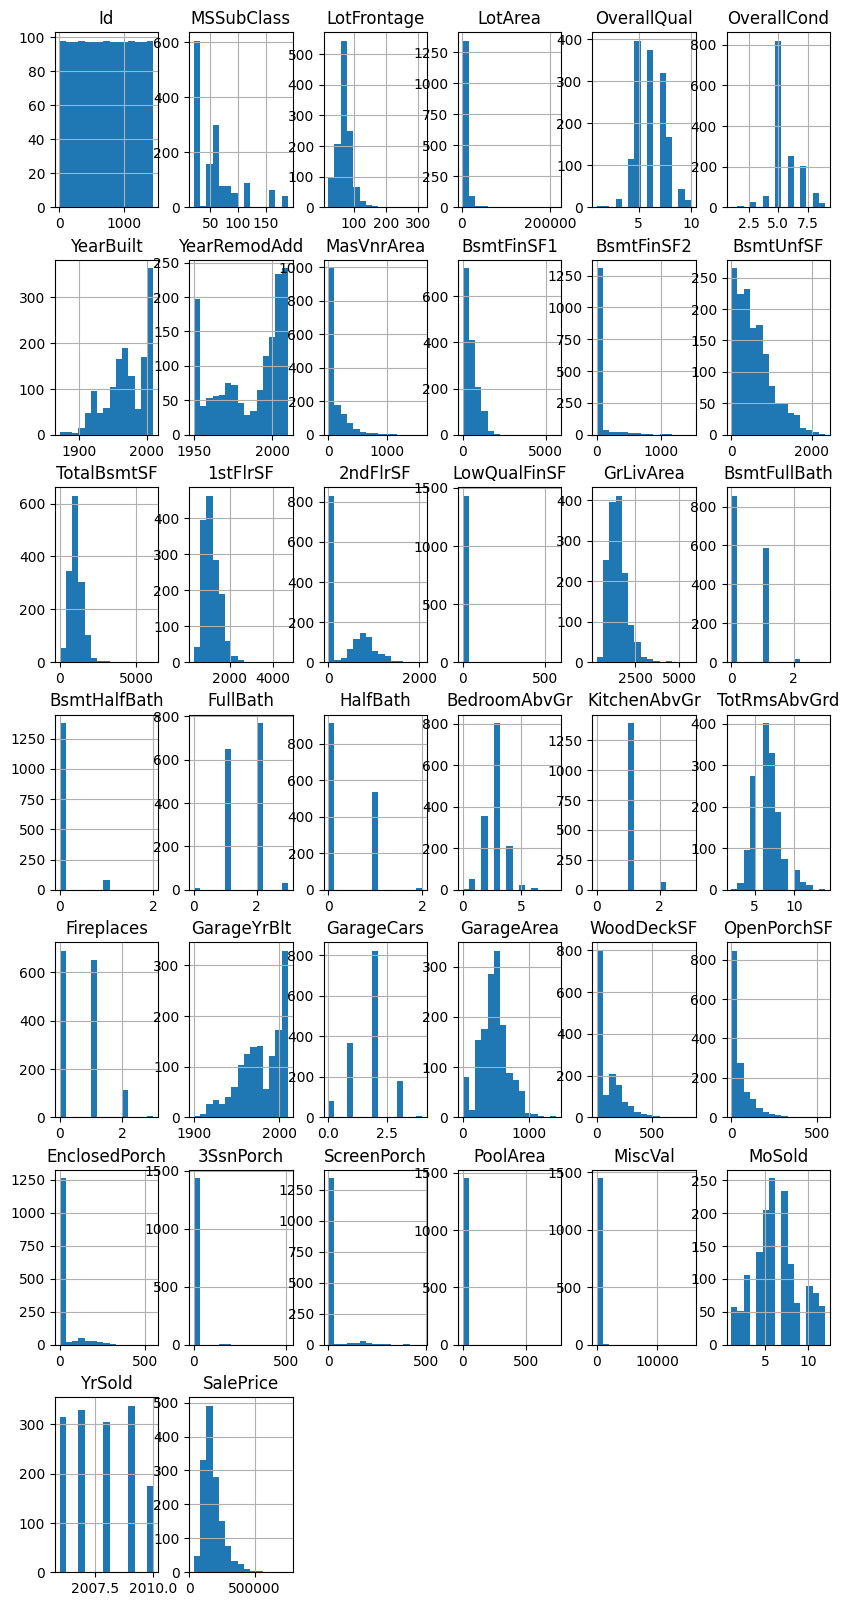

In [7]:
train_plot = PoltClass("../data/kaggle_house_pred_train.csv")
#  Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
#        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
#        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
#        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
#        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
#        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
#        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
#        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
#        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
#        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
#        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
#        'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
#        'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
#        'SaleCondition', 'SalePrice'],
#       dtype='object')

#print( train_data.select_dtypes(include='int').columns)
#train_plot.displayXY("Id","OverallCond")
train_data.hist(bins=15,figsize=(10,20))


训练数据集包括1460个样本，每个样本80个特征和1个标签，
而测试数据集包含1459个样本，每个样本80个特征。


In [8]:
print(train_data.shape)
print(test_data.shape)

print(type(train_data))

(1460, 81)
(1459, 80)
<class 'pandas.core.frame.DataFrame'>


让我们看看[**前四个和最后两个特征，以及相应标签**]（房价）。


In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


我们可以看到，(**在每个样本中，第一个特征是ID，**)
这有助于模型识别每个训练样本。
虽然这很方便，但它不携带任何用于预测的信息。
因此，在将数据提供给模型之前，(**我们将其从数据集中删除**)。


In [10]:

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

print(all_features)


      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454         160       RM         21.0     1936   Pave   NaN      Reg   
1455         160       RM         21.0     1894   Pave   NaN      Reg   
1456          20       RL        160.0    20000   Pave   NaN      Reg   
1457          85       RL         62.0    10441   Pave   NaN      Reg   
1458          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...  

## 数据预处理

如上所述，我们有各种各样的数据类型。
在开始建模之前，我们需要对数据进行预处理。
首先，我们[**将所有缺失的值替换为相应特征的平均值。**]然后，为了将所有特征放在一个共同的尺度上，
我们(**通过将特征重新缩放到零均值和单位方差来标准化数据**)：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。
现在，这些特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地说，我们标准化数据有两个原因：
首先，它方便优化。
其次，因为我们不知道哪些特征是相关的，
所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。


In [11]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# x.mean()返回每个特征的均值
# x.std()返回每个特征的标准差
# 这里有个很坑的点，如果你先把null填成均值，再标准化，那不相当与直接给null赋值为0 这里有点跳跃！！！
# 但是null 不等于 0 哦 
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features)

      MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0       0.067320       RL    -0.184443 -0.217841   Pave   NaN      Reg   
1      -0.873466       RL     0.458096 -0.072032   Pave   NaN      Reg   
2       0.067320       RL    -0.055935  0.137173   Pave   NaN      IR1   
3       0.302516       RL    -0.398622 -0.078371   Pave   NaN      IR1   
4       0.067320       RL     0.629439  0.518814   Pave   NaN      IR1   
...          ...      ...          ...       ...    ...   ...      ...   
1454    2.419286       RM    -2.069222 -1.043758   Pave   NaN      Reg   
1455    2.419286       RM    -2.069222 -1.049083   Pave   NaN      Reg   
1456   -0.873466       RL     3.884968  1.246594   Pave   NaN      Reg   
1457    0.655311       RL    -0.312950  0.034599   Pave   NaN      Reg   
1458    0.067320       RL     0.201080 -0.068608   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch  PoolArea PoolQC  Fence  \
0            Lvl    AllPub    

接下来，我们[**处理离散值。**]
这包括诸如“MSZoning”之类的特征。
(**我们用独热编码替换它们**)，
方法与前面将多类别标签转换为向量的方式相同
（请参见 :numref:`subsec_classification-problem`）。
例如，“MSZoning”包含值“RL”和“Rm”。
我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。
根据独热编码，如果“MSZoning”的原始值为“RL”，
则：“MSZoning_RL”为1，“MSZoning_RM”为0。
`pandas`软件包会自动为我们实现这一点。


In [12]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)

all_features.shape
# softmax 提到的独热编码

(2919, 331)

可以看到此转换会将特征的总数量从79个增加到331个。
最后，通过`values`属性，我们可以
[**从`pandas`格式中提取NumPy格式，并将其转换为张量表示**]用于训练。


In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## [**训练**]

首先，我们训练一个带有损失平方的线性模型。
显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查，
以查看数据中是否存在有意义的信息。
如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。
如果一切顺利，线性模型将作为*基线*（baseline）模型，
让我们直观地知道最好的模型有超出简单的模型多少。


In [14]:

loss = nn.MSELoss()

in_features = train_features.shape[1]



房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。
例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，
假设我们的预测偏差了10万美元，
然而那里一栋典型的房子的价值是12.5万美元，
那么模型可能做得很糟糕。
另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，
（在那里，房价中位数超过400万美元）
这可能是一个不错的预测。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [15]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

与前面的部分不同，[**我们的训练函数将借助Adam优化器**]
（我们将在后面章节更详细地描述它）。
Adam优化器的主要吸引力在于它对初始学习率不那么敏感。


In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$折交叉验证

本书在讨论模型选择的部分（ :numref:`sec_model_selection`）
中介绍了[**K折交叉验证**]，
它有助于模型选择和超参数调整。
我们首先需要定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。
具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。
注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。


In [17]:
def get_k_fold_data(k, i, X, y):
    # 确保 k 大于 1，否则抛出异常
    assert k > 1

    # 计算每个分区的大小，即数据总量除以折数 k
    fold_size = X.shape[0] // k

    # 初始化训练集和验证集的特征数据和目标数据
    X_train, y_train = None, None

    # 循环遍历每个分区
    for j in range(k):
        # 使用 slice 函数获取当前分区的数据切片索引范围
        idx = slice(j * fold_size, (j + 1) * fold_size)

        # 从原始数据中获取当前分区的特征数据和目标数据
        X_part, y_part = X[idx, :], y[idx]

        # 如果当前分区 j 等于当前的折数 i，则将其作为验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 否则将其添加到训练集中
        elif X_train is None: 
            X_train, y_train = X_part, y_part
        else:
            # 使用 torch.cat 将当前分区数据拼接到训练集中
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)

    # 返回训练集和验证集的特征数据和目标数据
    return X_train, y_train, X_valid, y_valid


In [36]:
def get_net():
    
    net = nn.Sequential(nn.Linear(in_features, 256),
                    #nn.ReLU(),
                    #nn.Linear(256, 360),
                    #nn.ReLU(),
                    #nn.Linear(360, 256),
                    #nn.ReLU(),
                    #nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 1))
    return net
    #net = nn.Sequential(nn.Linear(in_features,1)) 
print(get_net())
    

Sequential(
  (0): Linear(in_features=331, out_features=192, bias=True)
  (1): ReLU()
  (2): Linear(in_features=192, out_features=1, bias=True)
)


当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。


In [19]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    # 初始化训练集和验证集的误差和
    train_l_sum, valid_l_sum = 0, 0

    # 循环执行 k 折交叉验证
    for i in range(k):
        # 获取当前折的训练集和验证集数据
        data = get_k_fold_data(k, i, X_train, y_train)

        # 初始化神经网络模型
        net = get_net()

        # 训练神经网络并获取训练集和验证集的误差列表
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        # 累加训练集和验证集的最终误差
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        # 在第一折时绘制训练和验证误差的曲线图
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')

        # 打印当前折的训练和验证误差
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')

    # 返回平均训练误差和验证误差
    return train_l_sum / k, valid_l_sum / k


## [**模型选择**]

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。
找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。
有了足够大的数据集和合理设置的超参数，$K$折交叉验证往往对多次测试具有相当的稳定性。
然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。


折1，训练log rmse0.114526, 验证log rmse0.130795
折2，训练log rmse0.107531, 验证log rmse0.145340
折3，训练log rmse0.111634, 验证log rmse0.139596
折4，训练log rmse0.113989, 验证log rmse0.119461
折5，训练log rmse0.108160, 验证log rmse0.156918
5-折验证: 平均训练log rmse: 0.111168, 平均验证log rmse: 0.138422


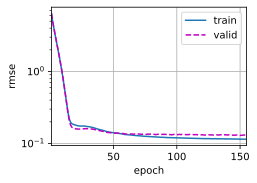

In [208]:
k, num_epochs, lr, weight_decay, batch_size = 5, 155, 0.021, 0.3,94

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多，
这表明模型过拟合了。
在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。
较少的过拟合可能表明现有数据可以支撑一个更强大的模型，
较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  [**提交Kaggle预测**]

既然我们知道应该选择什么样的超参数，
我们不妨使用所有数据对其进行训练
（而不是仅使用交叉验证中使用的$1-1/K$的数据）。
然后，我们通过这种方式获得的模型可以应用于测试集。
将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。


In [67]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

如果测试集上的预测与$K$倍交叉验证过程中的预测相似，
那就是时候把它们上传到Kaggle了。
下面的代码将生成一个名为`submission.csv`的文件。


训练log rmse：0.107601


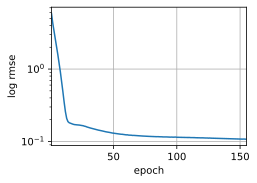

In [241]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
               


MLP:
Linear(331,256)
ReLU()
Dropout(0.5)
Linear(256, 1)

k, num_epochs, lr, weight_decay, batch_size = 5, 155, 0.021, 0.3,94

train log rmse：0.117352

接下来，如 :numref:`fig_kaggle_submit2`中所示，
我们可以提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的比较情况。
步骤非常简单。

* 登录Kaggle网站，访问房价预测竞赛页面。
* 点击“Submit Predictions”或“Late Submission”按钮（在撰写本文时，该按钮位于右侧）。
* 点击页面底部虚线框中的“Upload Submission File”按钮，选择要上传的预测文件。
* 点击页面底部的“Make Submission”按钮，即可查看结果。

![向Kaggle提交数据](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把预测提交给Kaggle，它有多好？
1. 能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


[Discussions](https://discuss.d2l.ai/t/1824)
